### 1. 필요한 라이브러리 호출 및 시각화 설정

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from imblearn.over_sampling import SMOTE

# 경고창 제거
import warnings
warnings.filterwarnings('ignore')

# 시각화 설정
plt.rc('font', family='Malgun Gothic')
plt.rc('axes', unicode_minus=False)
%config InlineBackend.figure_format = 'retina'


### 2. 데이터셋 불러오기

In [2]:
train_df = pd.read_csv('../Data/quarter_features.csv', index_col=0)
test_df = pd.read_csv('../Data/test_features.csv', index_col=0)

VKOSPI_Label
0.0    62
1.0    18
Name: count, dtype: int64
VKOSPI_Label
0.0    77.5
1.0    22.5
Name: proportion, dtype: float64


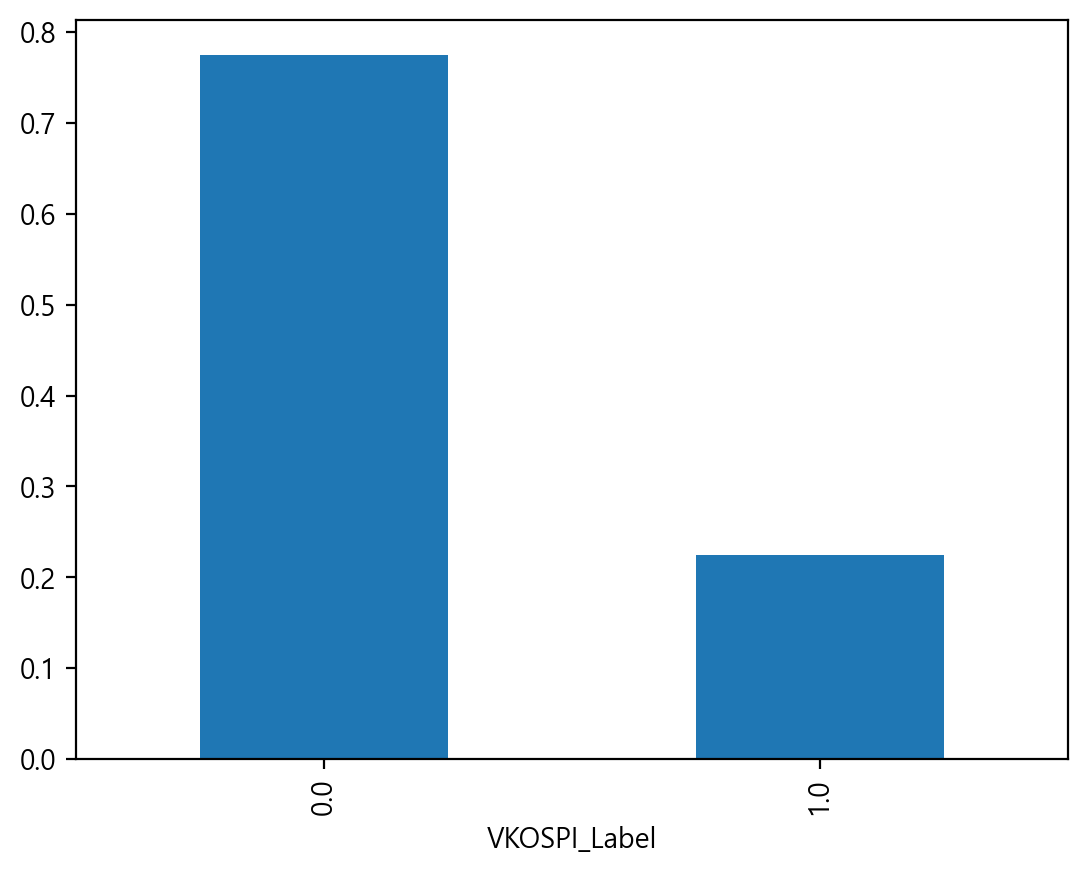

In [16]:
# 데이터 불균형 확인
import pandas as pd 
print(train_df['VKOSPI_Label'].value_counts())
train_df['VKOSPI_Label'].value_counts(normalize=True).plot(kind='bar')
print(train_df['VKOSPI_Label'].value_counts(normalize=True)*100)

### 3. 데이터셋 분리

In [4]:
# train/test셋 분리
X_train = train_df.drop(columns='VKOSPI_Label',axis=1)
y_train = train_df[['VKOSPI_Label']]
X_val = test_df.drop(columns='VKOSPI_Label',axis=1)
y_val = test_df[['VKOSPI_Label']]

* Feature selection을 통해 정해진 피처
1. 'VIX 당일변화량'과 'VIX 전날변동율' 중 중요도 낮은 피처 삭제 -> VIX 전날변동율 제거
2. '이론베이시스'와 '시장베이시스' 중 중요도 낮은 피처 삭제 -> 시장베이시스 제거
3. 중요도 값이 낮은 CALL_vol_fluc도 함께 삭제하기로 함.

selected_feature = ['이론베이시스','VIX 당일변화량', 'NAS 야간변동율', 'S&P 당일변화량','CALL_vol_change(%)','KS200 전날변동율','KOSPI 전날변동율']

In [5]:
X_train = X_train[['이론베이시스','VIX 당일변화량', 'NAS 야간변동율', 'S&P 당일변화량','CALL_vol_change(%)','KS200 전날변동율','KOSPI 전날변동율']]
X_val = X_val[['이론베이시스','VIX 당일변화량', 'NAS 야간변동율', 'S&P 당일변화량','CALL_vol_change(%)','KS200 전날변동율','KOSPI 전날변동율']]

### 4. Standard Scaling

In [6]:
# 표준화
features_to_standardize = ['이론베이시스','VIX 당일변화량', 'NAS 야간변동율', 'S&P 당일변화량','CALL_vol_change(%)','KS200 전날변동율','KOSPI 전날변동율']
scaler_standardize = StandardScaler()
X_train = scaler_standardize.fit_transform(X_train[features_to_standardize])
X_val = scaler_standardize.transform(X_val[features_to_standardize])

X_train = pd.DataFrame(X_train, columns=features_to_standardize)
X_val = pd.DataFrame(X_val, columns=features_to_standardize)

### 5. 오버샘플링 및 모델링

### 모델링
1. 트리기반 모델링

In [7]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.base import clone

# 데이터 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train.values.ravel())

# 모델별 하이퍼파라미터 그리드 설정
param_grid_dtree = {
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_rforest = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

param_grid_xgb = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

param_grid_lgbm = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2]
}

# 모델 목록
models = {
    'Decision Tree': [DecisionTreeClassifier(random_state=42), param_grid_dtree],
    'Random Forest': [RandomForestClassifier(random_state=42), param_grid_rforest],
    'XGBoost': [XGBClassifier(random_state=42), param_grid_xgb],
    'LightGBM': [LGBMClassifier(random_state=42), param_grid_lgbm]
}

# 결과를 저장할 리스트 초기화
results = []

# 각 모델에 대해 GridSearchCV 실행 및 평가
for name, (model, params) in models.items():
    clf = GridSearchCV(model, params, scoring='accuracy', cv=5)
    clf.fit(X_train_res, y_train_res)
    
    # 최적의 하이퍼파라미터 출력
    print(f"Best parameters for {name}: {clf.best_params_}")
    
    # 최적의 하이퍼파라미터로 모델 생성
    best_model = clone(model)
    best_model.set_params(**clf.best_params_)
    best_model.fit(X_train_res, y_train_res)
    
    # 검증 데이터셋에 대한 예측
    predictions = best_model.predict(X_val)
    
    # 성능 지표 계산
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions, average='binary')
    recall = recall_score(y_val, predictions, average='binary')
    f1 = f1_score(y_val, predictions, average='binary')
    
    # 결과 저장
    results.append([name, accuracy, precision, recall, f1])
    
    # train 데이터셋에 대한 예측 결과를 저장
    train_df[name + '_pred'] = best_model.predict(X_train)

# 결과 DataFrame 생성 및 출력
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(results_df)


Best parameters for Decision Tree: {'max_depth': 10, 'min_samples_split': 5}
Best parameters for Random Forest: {'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}
Best parameters for XGBoost: {'learning_rate': 0.2, 'max_depth': 3, 'n_estimators': 100}
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 50, number of negative: 49
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000098 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 241
[LightGBM] [Info] Number of data points in the train set: 99, number of used features: 7
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.505051 -> initscore=0.020203
[LightGBM] [Info] Start training from score 0.020203
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

0.0    62
1.0    62
Name: count, dtype: int64
0.0    50.0
1.0    50.0
Name: proportion, dtype: float64


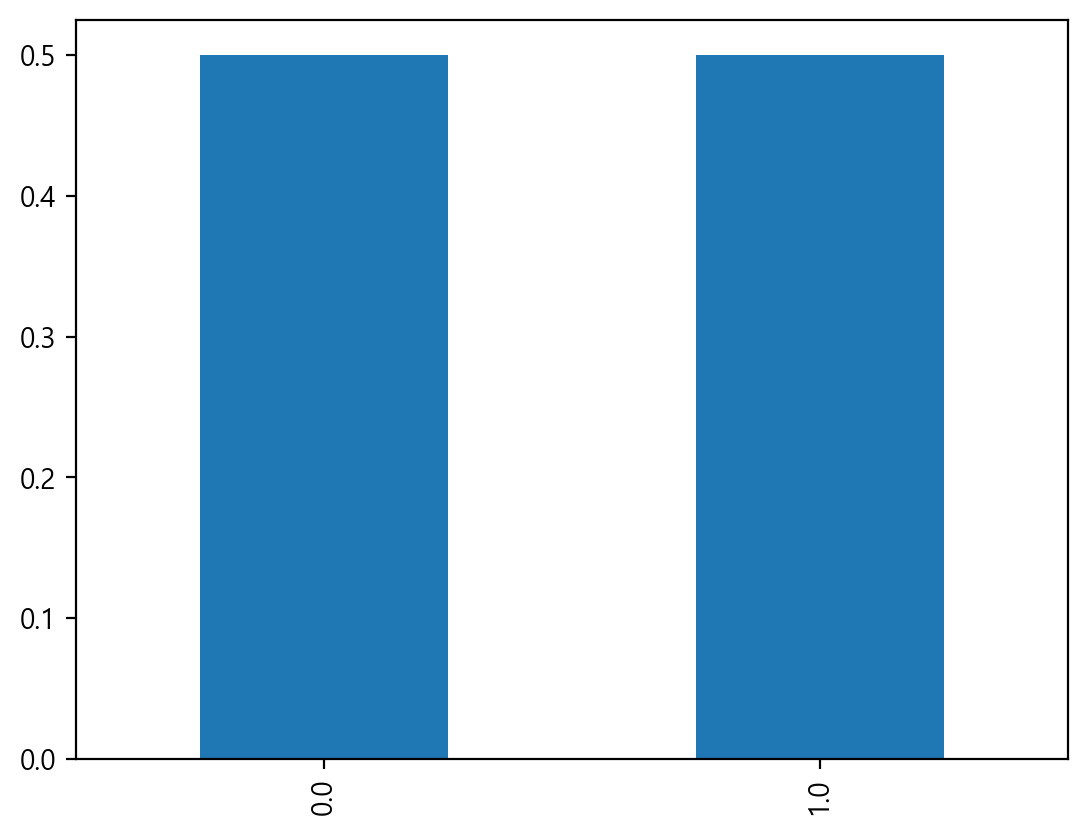

In [14]:
import pandas as pd

# y_train_res를 판다스 Series 객체로 변환
y_train_res_series = pd.Series(y_train_res)

# value_counts() 메소드로 각 클래스의 개수를 출력
print(y_train_res_series.value_counts())

# 데이터 불균형 확인
y_train_res_series.value_counts(normalize=True).plot(kind='bar')
print(y_train_res_series.value_counts(normalize=True)*100)


2. 선형기반 모델링

In [9]:
from sklearn.base import clone
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

# SMOTE를 사용하여 데이터 오버샘플링
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train.values.ravel())  # y_train을 1D array로 변환

# 모델별 하이퍼파라미터 그리드 설정
param_grid_svc = {
    'C': [0.1, 1, 10],
    'kernel': ['linear', 'rbf'],
    'gamma': [0.1, 1, 'scale']
}

param_grid_logreg = {
    'C': [0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga']
}

# 모델 목록
models = {
    'SVC': [SVC(), param_grid_svc],
    'Logistic Regression': [LogisticRegression(), param_grid_logreg]
}

# 결과를 저장할 리스트 초기화
results = []

# 각 모델에 대해 GridSearchCV 실행 및 평가
for name, (model, params) in models.items():
    clf = GridSearchCV(model, params, scoring='accuracy', cv=5)
    clf.fit(X_train_res, y_train_res)
    
    # 최적의 하이퍼파라미터 출력
    print(f"Best parameters for {name}: {clf.best_params_}")
    
    # 최적의 하이퍼파라미터로 모델 생성
    best_model = clone(model).set_params(**clf.best_params_)
    best_model.fit(X_train_res, y_train_res)
    
    # 검증 데이터셋에 대한 예측
    predictions = best_model.predict(X_val)
    
    # 성능 지표 계산
    accuracy = accuracy_score(y_val, predictions)
    precision = precision_score(y_val, predictions, average='binary')
    recall = recall_score(y_val, predictions, average='binary')
    f1 = f1_score(y_val, predictions, average='binary')
    
    # 결과 저장
    results.append([name, accuracy, precision, recall, f1])
    
    # train 데이터셋에 대한 예측 결과를 저장
    train_df[name + '_pred'] = best_model.predict(X_train)

# 결과 DataFrame 생성 및 출력
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Precision', 'Recall', 'F1 Score'])
print(results_df)


Best parameters for SVC: {'C': 10, 'gamma': 1, 'kernel': 'rbf'}
Best parameters for Logistic Regression: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
                 Model  Accuracy  Precision  Recall  F1 Score
0                  SVC  0.736842   0.000000     0.0  0.000000
1  Logistic Regression  0.473684   0.222222     0.4  0.285714
